# <font size=6> Прогнозирование оттока клиентов в сфере телекоммуникаций </font>

### <font size = 6> Информация о проекте </font>

Оператору связи необходимо спрогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Для решения поставленной задачи предоставлены персональные данные о некоторых клиентах - информация об их тарифах и договорах. 
Основные типы услуг компании: 
- стационарная телефонная связь с возможностью подключения телефонного аппарата к нескольким линиям одновременно.
- интернет с подключением двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Дополнительные услуги:
- интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- выделенная линия технической поддержки (TechSupport);
- облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Цель исследования** - разработать модель, прогнозирующую отток клиентов (метрика качества модели: AUC-ROC >= 0.85)

####  <font size = 5> План проекта </font>

<font size = 5> Ход исследования </font>

После предварительного анализа данных (см. п. `Общая информация о данных`) можно сказать, что:
- информация о пользователях представлена в четырех датасетах, соответственно, в начале проекта потребуется их объединение в единую таблицу;
- в процессе предобработки данных необходимо привести название признаков и строковые данные к единому стилю, обработать пропуски, скорректировать типы данных, проверить данные на дубликаты и аномалии. Учитывая разный объем данных в датасетах, после их объединения появяться пропуски, которые будут заполнены как `No` (т.е. клиент не пользуется данной услугой).

После предобработки данных можно приступать к разработке модели. Данные содержат категориальные и количественные признаки. Для подготовки признаков необходимо: сгенерировать новые признаки и удалить старые, проверить корреляцию признаков, проверить дисбаланс классов, разбить выборки на обучающую и тестовую (вместо валидационной выборки используется кросс-валидация), применить кодирование (используем OneHotEncoding, но для моделей бустинга не кодируем) и масштабирование признаков.

В проекте решается задача бинарной классификации, в качестве моделей планирую рассмотреть:
- логистическую регрессию;
- случайный лес;
- LightGBM.

Изменяя гиперпараметры моделей и анализируя *AUC-ROC* определить наилучшую модель. За наилучшую модель принимается модель с AUC-ROC не менее 0.85. Выполнить тестирование наилучшей модели.

<font size=5> План проекта </font>:

1. Общая информация о данных:
   - загрузка данных и предварительный анализ;
   - предобработка данных;
2. Разработка модели:
   - подготовка признаков;
   - построение моделей (перебор гиперпараметров, выборка лучшей модели по AUC-ROC на кросс-валидации);
   - тестирование модели
   - исследование важности признаков лучшей модели
3. Отчёт:
   - анализ пунктов проекта (выполнение пунктов, трудности проекта, ключевые шаги проекта)
   - описание лучшей модели (гиперпараметры, качество модели)
   - список признаков, используемых для обучения и описание их предобработки.

### <font size = 6> Общая информация о данных </font>

In [1]:
# установка последней версии scikit-learn (чтобы не было ошибки для OHE при применении drop_first и ignore)

!pip install scikit-learn==1.1.3

In [2]:
! pip install phik

In [3]:
# импорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 30723

#### <font size = 5> Загрузка данных и предварительный анализ </font>

<font size=5> Информация о договоре </font>

- `customerID` - код клиента;
- `BeginDate` - дата начала пользования услугами;
- `EndDate` - дата окончания пользования услугами;
- `Type` - тип оплаты (ежемесячный, годовой и т.д.);
- `PaperlessBilling` - безналичный расчет;
- `PaymentMethod` - способ оплаты;
- `MonthlyCharges` - ежемесячные платы на услуги;
- `TotalCharges` - всего потрачено денег на услуги;

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')

In [5]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6179,6328-ZPBGN,2018-11-01,No,Month-to-month,Yes,Bank transfer (automatic),95.15,1427.25
4794,0366-NQSHS,2019-12-01,No,Month-to-month,No,Mailed check,19.35,38.7
2601,7730-CLDSV,2014-02-01,No,Two year,Yes,Bank transfer (automatic),98.65,7315.88
5666,8318-LCNBW,2017-03-01,No,One year,No,Credit card (automatic),53.15,1953.26
516,3482-ABPKK,2017-10-01,No,One year,No,Mailed check,54.30,1626.83


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Промежуточный вывод.** Данные содержат 7043 строки, пропуски отсутствуют. Название признаков и строковые данные необходимо привести к корректному синтаксису. Для признаков `BeginDate`, `EndDate`, `TotalCharges` необходимо изменить тип данных. Из признака `EndDate` сгенерировать целевой признак (если `EndDate` не содержит дату, то клиента относим к классу 0, в противном случае к классу 1, т.е. клиент ушел), из признаков `BeginDate` и `EndDate` сгенерировать признак, характеризующий длительность пользования услугами компании. С целью избежания утечки информации, после формирования новых признаков удалить `BeginDate` и `EndDate`. Количественные признаки необходимо проверить на аномалии.

<font size=5> Персональные данные клиента </font>

- `Dependents` - наличие иждивенцев;
- `SeniorCitizen` - наличие пенсионного статуса по возрасту;
- `Partner` - наличие супруга(и).

In [7]:
personal = pd.read_csv('/datasets/personal_new.csv')

In [8]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
3425,0369-ZGOVK,Female,0,Yes,Yes
1308,3372-KWFBM,Male,1,No,No
5642,2320-TZRRH,Female,0,No,No
1549,4237-RLAQD,Male,0,No,No
6606,6518-LGAOV,Female,0,Yes,No


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Промежуточный вывод**. Данные содержат 7043 строки.Пропуски отсутствуют. Признаки не требуют предварительной обработки, кроме приведения к корректному синтаксису.

<font size=5> Информация об интернес-услугах </font>

- `InternetService` - тип подключения (DSL - телефонная линия, Fiber Optic - оптоволокно);
- `OnlineSecurity` - интернет-безопасность (блокировка небезопасных сайтов);
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` - интернет безопасность (антивирус);
- `TechSupport` - выделенная линия технической поддержки;
- `StreamingTV` - стриминговое телевидение;
- `StreamingMovies` - каталог фильмов.

In [10]:
internet = pd.read_csv('/datasets/internet_new.csv')

In [11]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3199,0324-BRPCJ,Fiber optic,No,Yes,No,No,Yes,Yes
5220,9388-ZEYVT,DSL,No,No,Yes,Yes,No,Yes
2690,5996-NRVXR,Fiber optic,Yes,Yes,Yes,Yes,Yes,No
2848,0512-FLFDW,Fiber optic,No,No,Yes,No,Yes,Yes
5160,2257-BOVXD,DSL,No,No,No,Yes,Yes,No


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Промежуточный вывод**. Данные содержат 5517 строк.Пропуски отсутствуют. Признаки не требуют предварительной обработки, кроме приведения к корректному синтаксису.

<font size=5> Информация об услугах телефонии </font>

- `MultipleLines` - наличие позможностей ведения параллельных линий во время звонка.

In [13]:
phone = pd.read_csv('/datasets/phone_new.csv')

In [14]:
phone.sample(5)

,customerID,MultipleLines
42,7760-OYPDY,No
2036,0788-DXBFY,No
4573,9909-IDLEK,Yes
2680,6176-YJWAS,Yes
4877,9689-PTNPG,No


In [15]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Промежуточный вывод**. Данные содержат 6361 строку.Пропуски отсутствуют. Признаки не требуют предварительной обработки, кроме приведения к корректному синтаксису.

#### <font size = 5> Предобработка данных </font>

<font size=5> Объединение датасетов </font>

In [16]:
data = contract.merge(personal, on = 'customerID', how = 'outer')
data = data.merge(internet, on = 'customerID', how = 'outer')
data = data.merge(phone, on = 'customerID', how = 'outer').reset_index(drop = True)

In [17]:
data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
721,8434-VGEQQ,2015-01-01,No,Two year,No,Credit card (automatic),20.55,1341.3,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2287,5440-FLBQG,2014-02-01,2016-06-01,Two year,Yes,Bank transfer (automatic),108.40,3035.2,Male,1,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
6706,7878-RTCZG,2020-01-01,No,Month-to-month,No,Mailed check,19.90,19.9,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3200,0895-DQHEW,2015-06-01,No,Month-to-month,Yes,Electronic check,104.30,5840.8,Male,0,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
104,3192-NQECA,2014-03-01,2018-03-01,Two year,Yes,Bank transfer (automatic),110.00,5385.6,Male,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes


<font size=5> Работа с текстом </font>

Приведем названия признаков и строковые данные к корректному синтаксису (приведение строковых признаков к нижнему индексу, в том числе позволит исключить неявные дубликаты).

In [18]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]

In [19]:
data.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [20]:
data = data.rename(columns={'customer_i_d': 'customer_id',
                            'streaming_t_v': 'streaming_tv'})

In [21]:
# приведение текста к нижнему регистру 

col = data.select_dtypes(include=['object']).columns

for i in col:
    data[i] = data[i].str.lower()

<font size=5> Работа с пропусками и дубликатами </font>

Пропуски в данных образовались вследствие разного объема объединенных датасетов. Пропуск означает, что клиент не использует данную услугу, поэтому логично будет пропуски заполнить как 'no'.

In [22]:
# определим количество пропусков в %

pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
customer_id,0.000000
begin_date,0.000000
end_date,0.000000
type,0.000000
paperless_billing,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.000000
gender,0.000000
senior_citizen,0.000000


In [23]:
data = data.fillna('no')

In [ ]:
# проверка на дубликаты

data.duplicated().sum()

<font size=5> Работа с типами данных: </font>

- `begin_date` и `end_date` содержат даты - привести к datetime (при этом в `end_date` заменить все 'no' на 2020-02-01 (актуальная дата выгрузки датасета));
- `total_charges` содержит числовые данные, но тип данных object;

In [25]:
# оставляем исходный столбец `end_date`

data.insert(loc = 3, column = 'end_date_old', value = data['end_date'])

In [26]:
# ставим "заглушку"

data.loc[data['end_date']=="no", "end_date"] = '2020-02-01'

In [27]:
# меняем тип данных

data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')

In [28]:
# проверка значений в `total_charges`

data['total_charges'].value_counts()

           11
20.45       6
101.0       5
1007.5      4
732.6       4
           ..
657.15      1
21.96       1
1410.28     1
6891.7      1
2054.7      1
Name: total_charges, Length: 6658, dtype: int64

Имеем 11 пустых значений с общей суммой трат за услуги. Поскольку пропусков незначительное количество, удалим их и изменим тип данных.

In [29]:
data = data[data['total_charges'] != " " ].reset_index(drop=True)

In [30]:
data['total_charges'] = data['total_charges'].astype(float)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   end_date_old       7032 non-null   object        
 4   type               7032 non-null   object        
 5   paperless_billing  7032 non-null   object        
 6   payment_method     7032 non-null   object        
 7   monthly_charges    7032 non-null   float64       
 8   total_charges      7032 non-null   float64       
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   int64         
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  internet_service   7032 non-null   object        
 14  online_s

**Промежуточный вывод**. На этапе предобработки данных выполнено:

- объединение таблиц в единый датасет;
- строковые данные и названия признаков приведены к корректному синтаксису;
- типы данных приведены к корректному;
- обработаны пропуски (пропуски заполнены как 'no' - клиент не пользуется услугой);
- удалено 0.16% данных, вследствие пропусков в признаке `total_charges` (общая сумма трат клиента);
- дубликатов не обнаружено.

Имеем датасет: объем - 7032 строки, количество признаков - 20.

#### <font size = 5> Исследовательский анализ данных </font>

<font size=5> Портрет клиента </font>

In [32]:
data['gender'].value_counts()

male      3549
female    3483
Name: gender, dtype: int64

In [33]:
data['senior_citizen'].value_counts()

0    5890
1    1142
Name: senior_citizen, dtype: int64

In [34]:
data['partner'].value_counts()

no     3639
yes    3393
Name: partner, dtype: int64

In [35]:
data['dependents'].value_counts()

no     4933
yes    2099
Name: dependents, dtype: int64

**Промежуточный вывод.** Клиентами телекома в равной степени являются как мужчины, так и женщины. 48% клиентов состоят в браке и 30% имеют детей, 16% клиентов являются пенсионерами.

<font size=5> Поведение клиента </font>

**Лояльность клиента (по длительности пользования услугами)**

Важной характеристикой клиента является длительность пользования услугами компании (лояльность клиента). Сгенерируем данный признак (рассчет будем вести в днях).

In [36]:
# добавление нового признака - `duration_days`

data.insert(loc = 3, column = 'duration_days', value = (data['end_date'] - data['begin_date']) / np.timedelta64 ( 1 , 'D'))

In [37]:
data.sample(3)

,customer_id,begin_date,end_date,duration_days,end_date_old,type,paperless_billing,payment_method,monthly_charges,total_charges,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3547,6134-kwtbv,2014-12-01,2020-02-01,1888.0,no,two year,no,bank transfer (automatic),23.4,1465.31,...,no,no,no,no,no,no,no,no,no,yes
4511,0103-csitq,2015-05-01,2019-06-01,1492.0,2019-06-01,one year,yes,bank transfer (automatic),109.4,5467.81,...,yes,no,fiber optic,no,yes,yes,yes,yes,yes,yes
865,2732-isezx,2019-09-01,2020-02-01,153.0,no,month-to-month,yes,mailed check,20.5,109.68,...,no,no,no,no,no,no,no,no,no,no


In [38]:
# замена типа данных в `duration_days` на int

data['duration_days'] = data['duration_days'].astype(int)

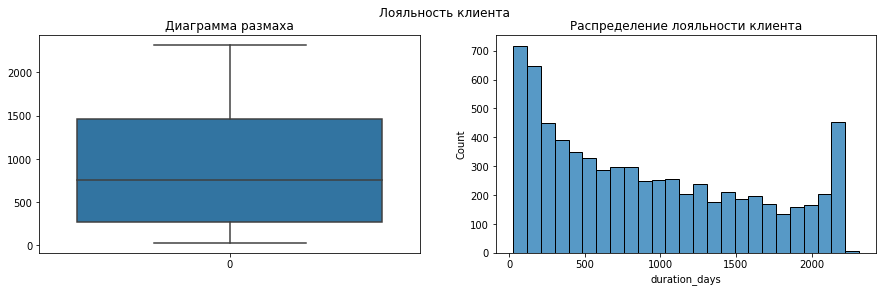

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Лояльность клиента')
sns.boxplot(data=data['duration_days'], ax=axes[0]).set_title('Диаграмма размаха')
sns.histplot(data=data['duration_days'], bins=25, ax=axes[1]).set_title('Распределение лояльности клиента');

In [40]:
data['duration_days'].describe()

count    7032.000000
mean      899.961320
std       682.738777
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: duration_days, dtype: float64

Можно выделить три группы клиентов: новые клиенты (пользуются услугами менее 9 месяцев), продвинутые клиенты (пользуются услугами от 9 месяцев до 2 лет), постоянные клиенты (пользуются услугами более 2 лет). 

Выделим **ушедших клиентов в отдельную таблицу - `customer_churn`** для анализа портрета клиента, склонного к оттоку.

In [41]:
# датасет с ушедшими клиентами

customer_churn = data.query('end_date != "2020-02-01"')

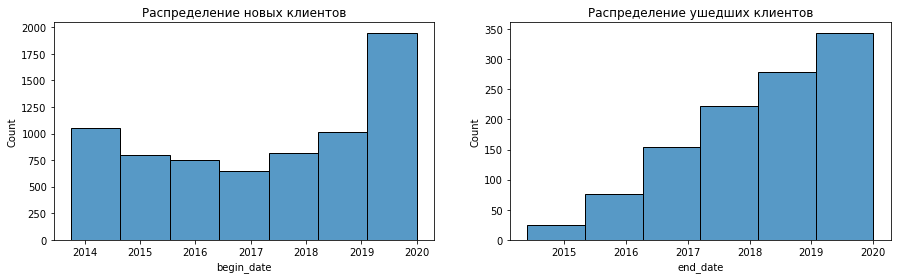

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=data['begin_date'], bins=7, ax=axes[0]).set_title('Распределение новых клиентов')
sns.histplot(data=customer_churn['end_date'], bins=6, ax=axes[1]).set_title('Распределение ушедших клиентов');

**Промежуточный вывод.** Компания начала работать с конца 2013 г (по предоставленной информации). Наибольшее количество клиентов было подключено в 2014 и 2020 гг. С 2014 г наблюдалось плавное снижение количества новых клиентов, которое сменилось ростом в 2017 г. В среднем, начиная с 2017 г, количество новых клиентов в 4 раза превышало количество ушедших в соответствующий год. По длительности пользования услугами компании среди клиентов можно выделить три группы:

- новые клиенты (менее 9 месяцев);
- продвинутые клиенты (от 9 месяцев до 2 лет);
- постоянные клиенты (более 2 лет).

<font size=5> Платежи </font>

In [43]:
data['type'].value_counts()

month-to-month    3875
two year          1685
one year          1472
Name: type, dtype: int64

In [44]:
data['paperless_billing'].value_counts()

yes    4168
no     2864
Name: paperless_billing, dtype: int64

In [45]:
data['payment_method'].value_counts()

electronic check             2365
mailed check                 1604
bank transfer (automatic)    1542
credit card (automatic)      1521
Name: payment_method, dtype: int64

Большинство клиентов (60%) предпочитают безналичный расчет. При этом 55% клиентов предпочитают ежемесячную оплату, 24% - двухгодичную оплату, 21% - ежегодную оплату. По способу оплаты большинство клиентов предпочитают electronic check, остальные категории в целом распределены равномерно:

- electronic check: 34% клиентов;
- mailed check: 23% клиентов;
- bank transfer (automatic): 22% клиентов;
- credit card (automatic): 21% клиентов.

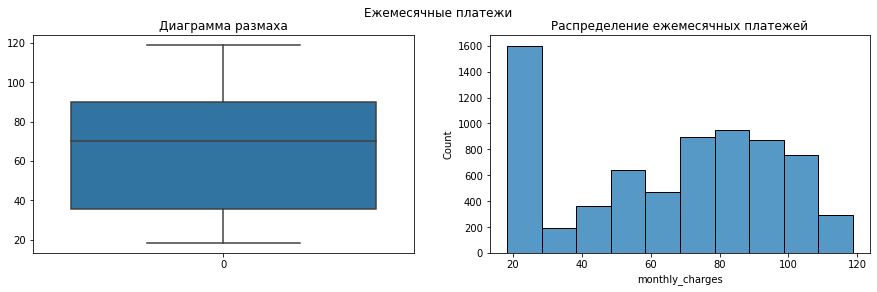

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Ежемесячные платежи')
sns.boxplot(data=data['monthly_charges'], ax=axes[0]).set_title('Диаграмма размаха')
sns.histplot(data=data['monthly_charges'], bins=10, ax=axes[1]).set_title('Распределение ежемесячных платежей');

In [47]:
data['monthly_charges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: monthly_charges, dtype: float64

Медианные ежемесячные траты клиентов составляют 70.4. По распределению ежемесячных трат можно выделить три группы клиентов:

- группа 1: траты до 30;
- группа 2: траты от 30 до 70;
- группа 3: траты более 70.

In [48]:
print("Количество клиентов группы 1:", data.query('monthly_charges <= 30')['monthly_charges'].count())
print("Количество клиентов группы 2:", data.query('monthly_charges > 30 & monthly_charges <= 70')['monthly_charges'].count())
print("Количество клиентов группы 3:", data.query('monthly_charges > 70')['monthly_charges'].count())

Количество клиентов группы 1: 1647
Количество клиентов группы 2: 1804
Количество клиентов группы 3: 3581


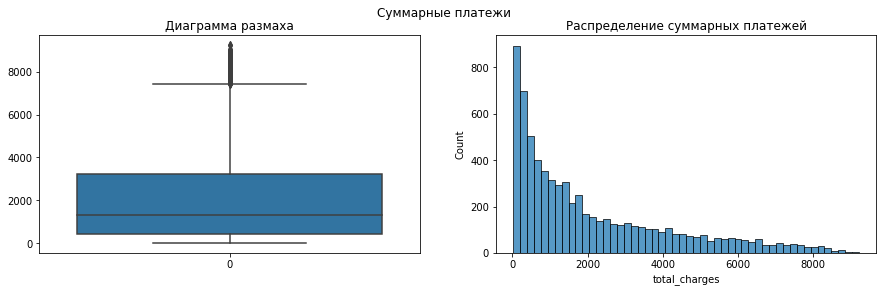

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Суммарные платежи')
sns.boxplot(data=data['total_charges'], ax=axes[0]).set_title('Диаграмма размаха')
sns.histplot(data=data['total_charges'], bins=50, ax=axes[1]).set_title('Распределение суммарных платежей');

In [50]:
data['total_charges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64

Суммарные платежи более 7450 на диаграмме размаха отнесены к "слабым" выбросам (т.е. превышают межквартильный размах в 1.5 и более раз). Проанализируем их.

In [51]:
data.query('total_charges > 7450')

,customer_id,begin_date,end_date,duration_days,end_date_old,type,paperless_billing,payment_method,monthly_charges,total_charges,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
17,9959-wofkt,2014-03-01,2020-02-01,2163,no,two year,no,bank transfer (automatic),106.70,8257.51,...,no,yes,fiber optic,yes,no,yes,no,yes,yes,yes
57,5067-xjqfu,2014-08-01,2020-02-01,2010,no,one year,yes,electronic check,108.45,7730.32,...,yes,yes,fiber optic,no,yes,yes,yes,yes,yes,yes
59,5954-bdfsg,2014-02-01,2020-02-01,2191,no,two year,yes,credit card (automatic),107.50,7740.00,...,no,no,fiber optic,no,no,yes,yes,yes,yes,yes
106,6728-dkuco,2014-02-01,2020-02-01,2191,no,one year,yes,electronic check,104.15,7498.80,...,yes,yes,fiber optic,yes,yes,no,no,yes,yes,yes
198,7255-ssfbc,2014-02-01,2020-02-01,2191,no,two year,yes,bank transfer (automatic),112.25,8324.46,...,yes,yes,fiber optic,no,yes,yes,yes,yes,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,3508-cfvzl,2014-03-01,2020-02-01,2163,no,two year,no,mailed check,111.30,7902.30,...,no,no,fiber optic,yes,yes,yes,yes,yes,yes,yes
6899,0530-ijvdb,2014-04-01,2020-02-01,2132,no,two year,yes,electronic check,114.60,8182.44,...,no,yes,fiber optic,yes,yes,yes,yes,yes,yes,yes
6902,8213-tazpm,2014-05-01,2020-02-01,2102,no,one year,yes,bank transfer (automatic),108.75,7728.86,...,yes,yes,fiber optic,no,yes,yes,yes,yes,yes,yes
6981,0218-qnvas,2014-03-01,2020-02-01,2163,no,one year,no,bank transfer (automatic),100.55,7638.78,...,yes,yes,fiber optic,no,yes,no,no,yes,yes,yes


In [52]:
print('Медианная длительность:', data.query('total_charges > 7450')['duration_days'].median(), 'дней')
print('Медиана ежемесячных платежей:', data.query('total_charges > 7450')['monthly_charges'].median())

Медианная длительность: 2191.0 дней
Медиана ежемесячных платежей: 110.5


Клиенты с суммарными тратами более 7450 в среднем пользуются услугами телекома 2191 день, а их ежемесячные платежи составляют около 110. Соответственно, данные суммарные траты смотрятся достаточно логично и не являются аномалиями. Также имеются совсем незначительные суммарные платежи, которые сопоставимы с минимальными ежемесячными тратами, можно предположить, что это клиенты, пользующиеся услугами недавно (данное предположение проверила, так и есть - это клиенты, которые подключились 2020-01-01).

**Промежуточный вывод.** Большинство клиентов пользуются безналичным расчетом (60%) с ежемесячной формой оплаты (55%). Медианные ежемесячные траты клиентов составляют 70.4. По распределению ежемесячных трат можно выделить три группы клиентов:

- группа 1: траты до 30 (1647 клиентов);
- группа 2: траты от 30 до 70 (1804 клиента);
- группа 3: траты более 70 (3581 клиентов).

<font size=5> Услуги </font>

In [53]:
data['internet_service'].value_counts()

fiber optic    3096
dsl            2416
no             1520
Name: internet_service, dtype: int64

In [54]:
data['online_security'].value_counts()

no     5017
yes    2015
Name: online_security, dtype: int64

In [55]:
data['online_backup'].value_counts()

no     4607
yes    2425
Name: online_backup, dtype: int64

In [56]:
data['device_protection'].value_counts()

no     4614
yes    2418
Name: device_protection, dtype: int64

In [57]:
data['tech_support'].value_counts()

no     4992
yes    2040
Name: tech_support, dtype: int64

In [58]:
data['streaming_tv'].value_counts()

no     4329
yes    2703
Name: streaming_tv, dtype: int64

In [59]:
data['streaming_movies'].value_counts()

no     4301
yes    2731
Name: streaming_movies, dtype: int64

In [60]:
data['multiple_lines'].value_counts()

no     4065
yes    2967
Name: multiple_lines, dtype: int64

**Промежуточный вывод.** Статистика использования услуг:

- интернетом пользуются 78% клиентов, из них 56% используют оптоволокно и 44% - DSL;
- интерент-безопасность используют 63% клиентов, из них 45,5% используют блокировку небезопасных сайтов и 54,5% - антивирус;
- облачное хранилище используют 34,5% клиентов;
- выделенной линией техноддержки пользуются 29% клиентов;
- стриминговое телевидение используют 38,4% клиентов;
- каталог фильмов используют 38,8% клиентов.

<font size=5> Клиенты, склонные к оттоку </font>

In [61]:
customer_churn.sample(5)

,customer_id,begin_date,end_date,duration_days,end_date_old,type,paperless_billing,payment_method,monthly_charges,total_charges,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1079,9878-tnqgw,2019-10-01,2019-11-01,31,2019-11-01,month-to-month,yes,electronic check,80.95,80.95,...,no,no,fiber optic,no,no,no,no,no,yes,no
6962,9972-vafjj,2015-09-01,2018-05-01,973,2018-05-01,one year,yes,electronic check,94.00,3188.48,...,yes,no,fiber optic,no,yes,yes,yes,yes,no,no
5572,5271-ynwvr,2014-05-01,2017-09-01,1219,2017-09-01,two year,yes,electronic check,113.15,4526.00,...,yes,yes,fiber optic,yes,yes,yes,yes,yes,yes,yes
1401,9337-srrni,2014-08-01,2019-05-01,1734,2019-05-01,two year,yes,credit card (automatic),25.30,1442.10,...,no,yes,no,no,no,no,no,no,no,yes
941,6353-brmma,2015-08-01,2017-04-01,609,2017-04-01,month-to-month,yes,bank transfer (automatic),104.10,2082.00,...,yes,yes,fiber optic,yes,yes,no,no,yes,yes,yes


In [62]:
customer_churn.describe()

,duration_days,monthly_charges,total_charges,senior_citizen
count,1101.000000,1101.000000,1101.000000,1101.000000
mean,924.863760,75.546004,2371.377275,0.210718
std,458.771309,29.116213,1581.862275,0.408003
min,28.000000,18.400000,77.840000,0.000000
25%,577.000000,56.150000,1048.050000,0.000000
50%,915.000000,84.200000,2139.030000,0.000000
75%,1249.000000,99.500000,3404.910000,0.000000
max,2129.000000,118.750000,7649.760000,1.000000


Всего за период работы компании ушло 1101 клиент. Средняя продолжительность пользования услугами телекома составила 2,5 г. Средние месячные траты ушедших клиентов составили 75.5 (т.е. основной отток наблюдается в группе 3 (группа с дорогими тарифами). Суммарные траты ушедших клиентов в среднем составляют 2371.

In [63]:
# функция для построения столбчатой диаграммы

def churn_plot(name_col):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    data.groupby(name_col)[name_col].count().plot(kind='bar', ax=ax, grid = True)
    customer_churn.groupby(name_col)[name_col].count().plot(kind='bar', ax=ax, color='red', grid = True)
    ax.legend(['Все клиенты', 'Ушедшие клиенты']);

male      573
female    528
Name: gender, dtype: int64

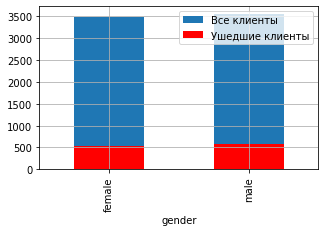

In [64]:
churn_plot('gender')
customer_churn['gender'].value_counts()

yes    719
no     382
Name: partner, dtype: int64

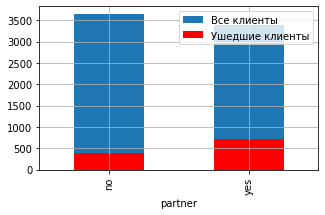

In [65]:
churn_plot('partner')
customer_churn['partner'].value_counts()

no     733
yes    368
Name: dependents, dtype: int64

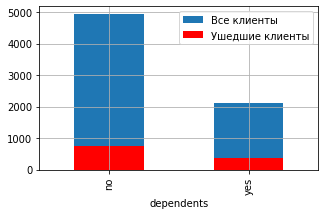

In [66]:
churn_plot('dependents')
customer_churn['dependents'].value_counts()

0    869
1    232
Name: senior_citizen, dtype: int64

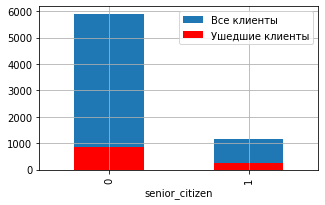

In [67]:
churn_plot('senior_citizen')
customer_churn['senior_citizen'].value_counts()

fiber optic    595
dsl            346
no             160
Name: internet_service, dtype: int64

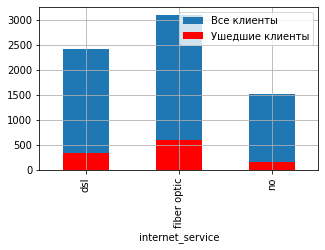

In [68]:
churn_plot('internet_service')
customer_churn['internet_service'].value_counts()

**Промежуточный вывод**. За 7 лет деятельности компании ушло 1101 клиент:

- средняя продолжительность пользования услугами составляет 2,5 г. 
- средние месячные траты ушедшего клиента составляют 75.5 (соотвественно уходят клиенты дорогого тарифа (группа 3))
- средние суммарные траты ушедшего клиента составляют 2371.

Отток клиента не зависит от гендера (можно предположить, что данный признак не будет оказывать большое влияние на модель). Наибольший отток наблюдается среди клиетов, состоящих в браке, пенсионеров и клиентов, которые пользуются услугами интернета через оптоволокно.

### <font size = 6> Разработка модели </font>

#### <font size = 5> Подготовка признаков </font>

In [69]:
# добавление целевого признака - `churn`

data['churn'] = (data['end_date_old'] != 'no').astype(int)
data.sample(3)

,customer_id,begin_date,end_date,duration_days,end_date_old,type,paperless_billing,payment_method,monthly_charges,total_charges,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
4104,7184-lruur,2018-04-01,2020-02-01,671,no,one year,no,bank transfer (automatic),65.25,1535.99,...,no,dsl,no,yes,yes,no,yes,no,no,0
4731,3088-lhefh,2019-03-01,2020-02-01,337,no,month-to-month,yes,bank transfer (automatic),79.00,929.83,...,no,fiber optic,yes,no,no,no,no,no,yes,0
3288,2041-jijci,2019-09-01,2020-02-01,153,no,month-to-month,yes,electronic check,64.00,320.00,...,no,dsl,no,yes,no,no,no,yes,yes,0


Признаки `customer_id`, `begin_date`, `end_date`, `end_date_old` удалим.

In [70]:
data = data.drop(['customer_id', 'begin_date', 'end_date', 'end_date_old'], axis = 1)

Очевидно, что в данных присутствует дисбаланс классов (класс 1 - абонент ушел, класс 0 - абонент остался). Проверим их соотношение.

In [71]:
print('Класс 1:', data.query('churn == 1')['churn'].count())
print('Класс 0:', data.query('churn == 0')['churn'].count())

Класс 1: 1101
Класс 0: 5931


Объем данных в классе 0 в 5 раз превышает объем класса 1, для балансировки классов будет использоваться class_weight = 'balanced'.

<font size=5> Анализ корреляции </font>

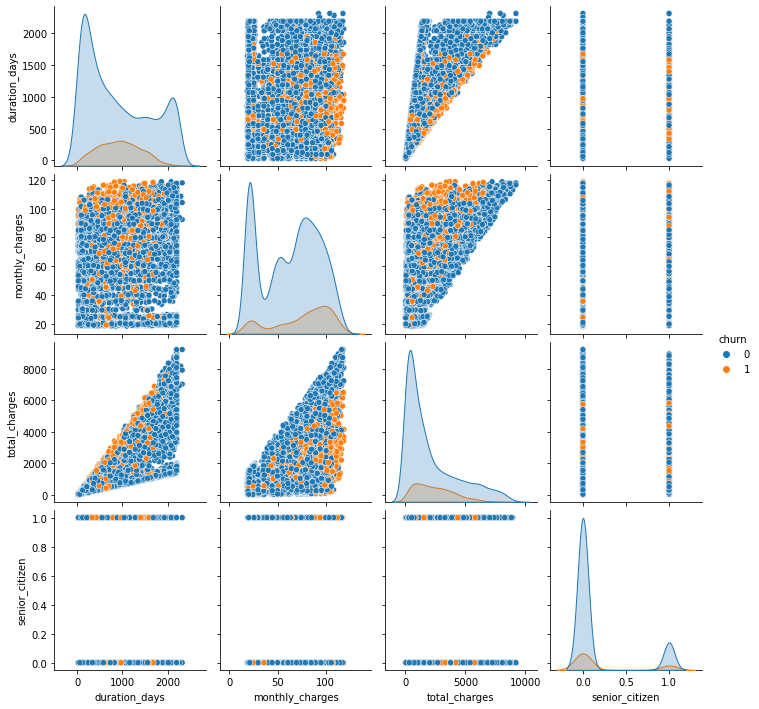

In [72]:
sns.pairplot(data, hue = 'churn'); 

Заметна линейная корреляция между `duration_days` и `total_charges`, а также `total_charges` и `monthly_charges`, что вполне логично.

In [73]:
data.phik_matrix().style.background_gradient(cmap='coolwarm')

interval columns not set, guessing: ['duration_days', 'monthly_charges', 'total_charges', 'senior_citizen', 'churn']


,duration_days,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn
duration_days,1.000000,0.635623,0.018839,0.348275,0.387649,0.847572,0.000000,0.065128,0.450246,0.197317,0.058903,0.394666,0.416097,0.429177,0.403311,0.340939,0.338454,0.397584,0.374101
type,0.635623,1.000000,0.106151,0.277528,0.388557,0.470700,0.000000,0.085800,0.179294,0.146126,0.503776,0.152239,0.099016,0.137817,0.180169,0.067123,0.070375,0.065750,0.094622
paperless_billing,0.018839,0.106151,1.000000,0.368945,0.467547,0.202168,0.000000,0.241715,0.010489,0.170650,0.231145,0.000000,0.196937,0.161234,0.055354,0.344114,0.325351,0.253299,0.082789
payment_method,0.348275,0.277528,0.368945,1.000000,0.398849,0.334563,0.000000,0.291989,0.244661,0.222859,0.323013,0.261704,0.282245,0.306678,0.270893,0.377241,0.378375,0.339987,0.214300
monthly_charges,0.387649,0.388557,0.467547,0.398849,1.000000,0.711015,0.005522,0.304546,0.204575,0.182283,0.919005,0.550855,0.629276,0.667621,0.576163,0.835680,0.833111,0.676393,0.225823
total_charges,0.847572,0.470700,0.202168,0.334563,0.711015,1.000000,0.000000,0.136856,0.383135,0.085809,0.489363,0.522660,0.623588,0.642431,0.550988,0.642937,0.644346,0.573224,0.303758
gender,0.000000,0.000000,0.000000,0.000000,0.005522,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.016788,0.007277,0.000000,0.000000,0.000000,0.000000,0.000000,0.008800
senior_citizen,0.065128,0.085800,0.241715,0.291989,0.304546,0.136856,0.000000,1.000000,0.018075,0.323629,0.160452,0.056897,0.102206,0.090818,0.092485,0.163223,0.185621,0.221386,0.085708
partner,0.450246,0.179294,0.010489,0.244661,0.204575,0.383135,0.000000,0.018075,1.000000,0.651635,0.000000,0.222040,0.219762,0.237725,0.186312,0.192973,0.183090,0.220874,0.227597
dependents,0.197317,0.146126,0.170650,0.222859,0.182283,0.085809,0.000000,0.323629,0.651635,1.000000,0.107328,0.124648,0.031464,0.010181,0.096565,0.017176,0.056742,0.032697,0.048710


Можно отметить значимую корреляцию между:

- `total_charges` и `duration-days` (0,85);
- `internet_service` и `monthly_charges` (0,92);
- `streaming_tv` и `monthly_charges` (0,83);
- `streaming_movies` и `monthly_charges` (0,83).

Поскольку используем линейную модель, удалим коррелирующие признаки: `total_charges`, `internet_service`, `streaming_tv`, `streaming_movies`.

In [74]:
data = data.drop(['total_charges', 'internet_service', 'streaming_tv', 'streaming_movies'], axis = 1)

<font size = 5> Разбиение данных на выборки</font>

In [75]:
# выделим признаки и целевой признак

target = data['churn']
features = data.drop('churn', axis=1)

In [76]:
# выделим тестовую выборку

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE,
                                                                            stratify = target)

In [77]:
print('Объем обучающей выборки:', features_train.shape)
print('Объем тестовой выборки:', features_test.shape)

Объем обучающей выборки: (5274, 14)
Объем тестовой выборки: (1758, 14)


Поскольку для LGBM кодировать категориальные признаки не требуется, выделим для нее отдельно выборки.

In [78]:
lgbm_features_train = features_train.copy()
lgbm_features_test = features_test.copy()

<font size=5> Кодирование признаков </font>

Рассматриваемые модели машинного обучения работают с количественными признаками. Преобразуем имеющиеся в датасете качественные признаки в количественные, используя OHE. Метод OHE выполняет преобразование признаков таким образом, что с ними могут работать как логистическая регрессия, так и модели на основе деревьев.

In [79]:
# категориальные признаки в обучающей выборке

ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'multiple_lines']

In [80]:
# создаем encoder: drop - избегаем дамми-ловушки, ignore - игнорируем ранее невстречающиеся значения признака

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки

encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок

features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)
features_train.head()

,duration_days,monthly_charges,senior_citizen,type_one year,type_two year,paperless_billing_yes,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,gender_male,partner_yes,dependents_yes,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,multiple_lines_yes
6104,641,75.3,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3841,62,49.2,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3524,518,69.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2370,2163,109.7,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3406,62,59.5,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [81]:
# энкодером, который обучен на обучающей выборке, кодируем тестовую

features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
features_test = features_test.drop(ohe_features, axis=1)
features_test.head()

,duration_days,monthly_charges,senior_citizen,type_one year,type_two year,paperless_billing_yes,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,gender_male,partner_yes,dependents_yes,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,multiple_lines_yes
4595,92,35.10,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2532,2191,113.40,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3877,549,88.85,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1855,2163,19.45,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
632,306,20.35,0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# количество признаков в выборках

features_train.shape, features_test.shape

((5274, 17), (1758, 17))

In [83]:
# разница признаков в тренировочной и тестовой выборках

(features_train.columns != features_test.columns).sum()

0

<font size=5> Масштабирование признаков </font>

In [84]:
# скрываем предупреждение Python

pd.options.mode.chained_assignment = None

# масштабируем признаки выборок

numeric = ['duration_days', 'monthly_charges']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#### <font size = 5> Построение моделей </font>

<font size=5> Логистическая регрессия </font>

In [85]:
model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight = 'balanced', max_iter=1000) 
param = {'C': [0.01, 0.1, 1, 10, 20, 100] }

In [86]:
%%time

param_lr = GridSearchCV(model_lr, param, scoring="roc_auc", n_jobs=-1, cv=5)
param_lr.fit(features_train, target_train)

CPU times: user 11.4 s, sys: 15.2 s, total: 26.6 s
Wall time: 26.6 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=30723),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10, 20, 100]},
             scoring='roc_auc')

In [87]:
print(f"best score: {param_lr.best_score_}")
print(f"best params: {param_lr.best_params_}")

best score: 0.7487276820070011
best params: {'C': 10}


<font size=5> Случайный лес </font>

In [88]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
param = {'max_depth':np.arange(2, 21, step=2),
         'n_estimators':np.arange(10, 510, step=20)}

In [89]:
%%time

param_rf = GridSearchCV(model_rf, param, scoring="roc_auc", n_jobs=-1, cv=5, verbose=10)
param_rf.fit(features_train, target_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5; 1/250] START max_depth=2, n_estimators=10..............................
[CV 1/5; 1/250] END max_depth=2, n_estimators=10;, score=0.778 total time=   0.0s
[CV 2/5; 1/250] START max_depth=2, n_estimators=10..............................
[CV 2/5; 1/250] END max_depth=2, n_estimators=10;, score=0.795 total time=   0.0s
[CV 3/5; 1/250] START max_depth=2, n_estimators=10..............................
[CV 3/5; 1/250] END max_depth=2, n_estimators=10;, score=0.782 total time=   0.0s
[CV 4/5; 1/250] START max_depth=2, n_estimators=10..............................
[CV 4/5; 1/250] END max_depth=2, n_estimators=10;, score=0.776 total time=   0.0s
[CV 5/5; 1/250] START max_depth=2, n_estimators=10..............................
[CV 5/5; 1/250] END max_depth=2, n_estimators=10;, score=0.785 total time=   0.0s
[CV 1/5; 2/250] START max_depth=2, n_estimators=30..............................
[CV 1/5; 2/250] END max_depth=2, n_estim

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=30723),
             n_jobs=-1,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490])},
             scoring='roc_auc', verbose=10)

In [90]:
print(f"best score: {param_rf.best_score_}")
print(f"best params: {param_rf.best_params_}")

best score: 0.8254726934315656
best params: {'max_depth': 8, 'n_estimators': 250}


<font size=5> LightGBM (берем некодированные признаки) </font>

In [91]:
# изменим тип данных категориальных признаков для LightGMB

for col in ohe_features:
    lgbm_features_train[col] = lgbm_features_train[col].astype('category')
    lgbm_features_test[col] = lgbm_features_test[col].astype('category')

In [92]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight ='balanced')

param = [{'n_estimators': np.arange(50, 711, step=10), 
          'max_depth': np.arange(2, 21, step=2),
          'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}]

param = [{'n_estimators': [590, 600], 
          'max_depth': [2, 4],
          'learning_rate': [0.3, 0.5]}]


param_lgbm= GridSearchCV(model_lgbm, param, scoring='roc_auc', n_jobs=-1, cv=3, verbose=10)
param_lgbm.fit(lgbm_features_train, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START learning_rate=0.3, max_depth=2, n_estimators=590............
[CV 1/3; 1/8] END learning_rate=0.3, max_depth=2, n_estimators=590;, score=0.895 total time= 1.3min
[CV 2/3; 1/8] START learning_rate=0.3, max_depth=2, n_estimators=590............
[CV 2/3; 1/8] END learning_rate=0.3, max_depth=2, n_estimators=590;, score=0.894 total time= 1.1min
[CV 3/3; 1/8] START learning_rate=0.3, max_depth=2, n_estimators=590............
[CV 3/3; 1/8] END learning_rate=0.3, max_depth=2, n_estimators=590;, score=0.912 total time=  43.6s
[CV 1/3; 2/8] START learning_rate=0.3, max_depth=2, n_estimators=600............
[CV 1/3; 2/8] END learning_rate=0.3, max_depth=2, n_estimators=600;, score=0.895 total time=  44.5s
[CV 2/3; 2/8] START learning_rate=0.3, max_depth=2, n_estimators=600............
[CV 2/3; 2/8] END learning_rate=0.3, max_depth=2, n_estimators=600;, score=0.894 total time=  46.1s
[CV 3/3; 2/8] START learning_rate=0

GridSearchCV(cv=3,
             estimator=LGBMClassifier(class_weight='balanced',
                                      random_state=30723),
             n_jobs=-1,
             param_grid=[{'learning_rate': [0.3, 0.5], 'max_depth': [2, 4],
                          'n_estimators': [590, 600]}],
             scoring='roc_auc', verbose=10)

In [93]:
print(f"best score: {param_lgbm.best_score_}")
print(f"best params: {param_lgbm.best_params_}")

best score: 0.900434809863688
best params: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 590}


**Промежуточный вывод.** Для решения поставленной задачи рассмотрены следующие модели:

- логистическая регрессия (auc-roc = 0.75);
- случайный лес (auc-roc = 0.83);
- LightGBM (auc-roc = 0.9).

Наилучшую метрику auc-roc на обучающей выборки показала модель LightGBM с гиперпараметрами {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 590}.

#### <font size = 5> Тестирование и исследование важности признаков модели LightGBM </font>

<font size=5> Тестирование модели </font>

In [94]:
# генерация и обучение модели на полной train-выборке с наилучшими параметрами

model_lgbm = LGBMClassifier(learning_rate=0.3, max_depth=2, n_estimators=590, 
                            random_state=RANDOM_STATE, class_weight = 'balanced')
model_lgbm.fit(lgbm_features_train, target_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.3, max_depth=2,
               n_estimators=590, random_state=30723)

In [95]:
# рассчет auc-roc на тесте

probabilities_test = model_lgbm.predict_proba(lgbm_features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = np.round(roc_auc_score(target_test, probabilities_one_test), 2)
fpr,tpr,thresholds = roc_curve(target_test, probabilities_one_test)

In [96]:
print('Метрика AUC-ROC для LightGBM на тесте:', auc_roc)

Метрика AUC-ROC для LightGBM на тесте: 0.9


<font size = 5> Исследование важности признаков </font>

In [97]:
# датасет с признаками и их значимость

feature_imp = pd.DataFrame(sorted(zip(model_lgbm.feature_importances_,lgbm_features_train.columns)), columns=['Value','Feature'])

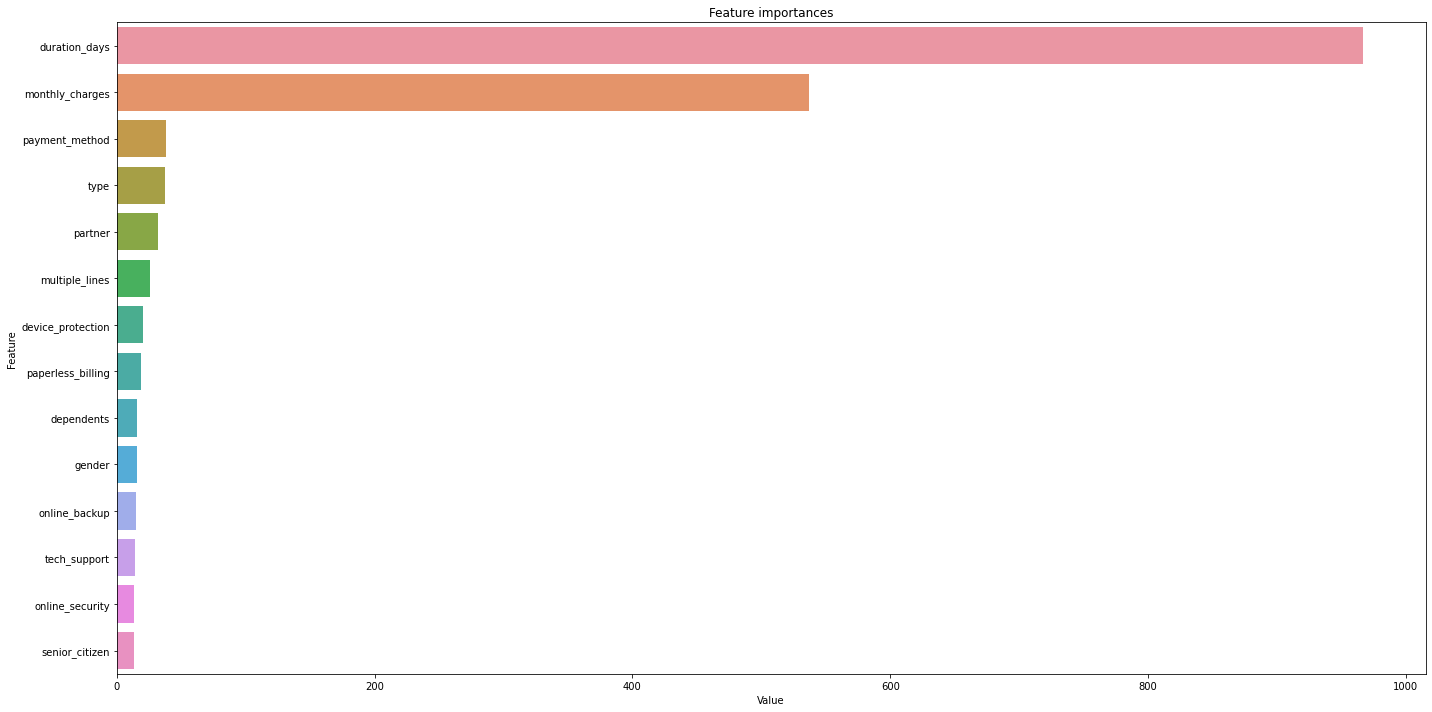

In [98]:
# построение графика важности признаков

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importances')
plt.tight_layout();

**Промежуточный вывод.** Модель LightGBM {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 590}:

- auc-roc на тестовой выборке: 0.9;
- наиболее важные признаки:
  - `duration_days`;
  - `monthly_charges`;
- к существенным признакам можно отнести:
  - `payment_method`;
  - `type`;
  - `partner`;
  - `multiple_lines`;
  - `device_protection`
  - `paperless_billing`

Остальные признаки незначимы для модели.

#### <font size=5> Оптимизация модели </font>

Удаление незначимых признаков.

In [99]:
features_train_opt = lgbm_features_train.drop(['senior_citizen', 
                                               'online_security', 
                                               'tech_support', 
                                               'online_backup', 
                                               'gender', 
                                               'dependents'], axis = 1)

features_test_opt = lgbm_features_test.drop(['senior_citizen', 
                                             'online_security', 
                                             'tech_support', 
                                             'online_backup', 
                                             'gender', 
                                             'dependents'], axis = 1)

In [100]:
features_train_opt.sample(3)

,duration_days,type,paperless_billing,payment_method,monthly_charges,partner,device_protection,multiple_lines
5673,31,month-to-month,no,electronic check,35.00,yes,no,no
2846,1949,two year,yes,mailed check,90.60,yes,yes,yes
3336,1218,one year,no,credit card (automatic),62.05,no,yes,no


In [101]:
# генерация и обучение модели на оптимизированной train-выборке с наилучшими параметрами

model_lgbm_opt = LGBMClassifier(learning_rate=0.3, max_depth=2, n_estimators=590, 
                            random_state=RANDOM_STATE, class_weight = 'balanced')
model_lgbm_opt.fit(features_train_opt, target_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.3, max_depth=2,
               n_estimators=590, random_state=30723)

In [102]:
# рассчет auc-roc на тесте

probabilities_test_opt = model_lgbm_opt.predict_proba(features_test_opt)
probabilities_one_test_opt = probabilities_test_opt[:, 1]
auc_roc_opt = np.round(roc_auc_score(target_test, probabilities_one_test_opt),2)
fpr_opt, tpr_opt, thresholds_opt = roc_curve(target_test, probabilities_one_test_opt)

In [103]:
print('Метрика AUC-ROC для оптимизированной LightGBM на тесте:', auc_roc_opt)

Метрика AUC-ROC для оптимизированной LightGBM на тесте: 0.9


<Figure size 432x288 with 0 Axes>

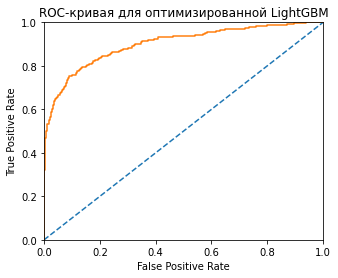

In [104]:
# график кривой auc-roc

plt.figure()

plt.figure(figsize=(5,4))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_opt,tpr_opt)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для оптимизированной LightGBM')

plt.show()

<font size=5> Рассчитаем дополнительные метрики </font>

**F1-мера**

In [116]:
# рассчет F1-меры

predicted_test = model_lgbm.predict(lgbm_features_test)
F1 = np.round(f1_score(target_test, predicted_test),2)
F1

0.65

In [117]:
# рассчет F1-меры оптимизированной модели

predicted_test_opt = model_lgbm_opt.predict(features_test_opt)
F1_opt = f1_score(target_test, predicted_test_opt)
F1

0.65

**Полнота модели (насколько хорошо модель распознает класс 1 - отток клиентов)**

In [118]:
# рассчет recall

rec = recall_score(target_test, predicted_test)
np.round(rec, 2)

0.73

In [119]:
# рассчет recall оптимизированной модели

rec_opt = recall_score(target_test, predicted_test_opt)
np.round(rec_opt, 2)

0.75

**Точность модели (насколько хорошо размечен класс 0)**

In [120]:
# рассчет accuracy_score

acc = accuracy_score(target_test, predicted_test)
np.round(acc, 2)

0.88

In [121]:
# рассчет accuracy_score оптимизированной модели

acc_opt = accuracy_score(target_test, predicted_test_opt)
np.round(acc_opt, 2)

0.88

**Матрица-ошибок**

In [105]:
# LightGBM

target_pred = model_lgbm.predict(lgbm_features_test)
conf_matrix = confusion_matrix(target_test, target_pred, normalize='true')

In [106]:
# оптимизированная LightGBM

target_pred_opt = model_lgbm_opt.predict(features_test_opt)
conf_matrix_opt = confusion_matrix(target_test, target_pred_opt, normalize='true')

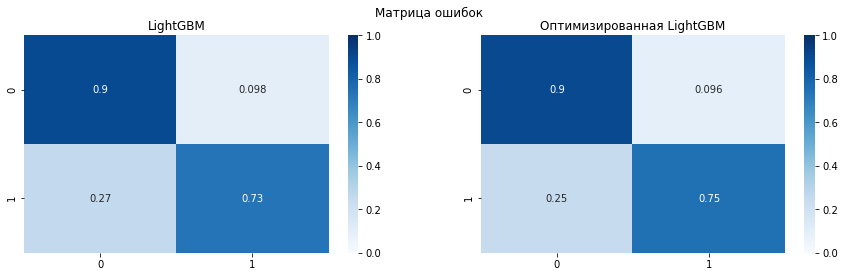

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Матрица ошибок')
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True, cmap='Blues', vmin=0, vmax=1, ax=axes[0]).set_title('LightGBM')
sns.heatmap(data=pd.DataFrame(conf_matrix_opt), annot=True, cmap='Blues', vmin=0, vmax=1,ax=axes[1]).set_title('Оптимизированная LightGBM')
plt.show()

**Промежуточные выводы.** В целом удаление признаков не повлияло на метрики модели. При сравнении моделей получены следующие результаты:

- auc-roc для LightGBM и оптимизированной LightGBM: 0.9;
- F1-мера для LightGBM и оптимизированной LightGBM: 0.65;
- accuracy для LightGBM и оптимизированной LightGBM: 0.88;

При этом полнота модели (recall) для оптимизированной LightGBM несколько выше, чем у LightGBM и составляет 0.75 и 0.73 соответственно.

На основе модели для 9.8% (9.6% после оптимизации) клиентов будут предложены лишние промо-коды (ошибка 1 рода), а для 27% (25% после оптимизации) клиентов, склонных к оттоку, промо-код не будет предложен (ошибка 2 рода). 

<font size=5> Сравнение с константной моделью </font>

Сравним точность модели с **константной моделью** для проверки адекватности (за константную модель примем модель, которая всегда выдает 1, т.е. моделируем ситуацию при которой предложили промо-код всем клиентам).

In [114]:
# рассчет f1-меры

dummy_model = DummyClassifier(strategy='constant', constant=1).fit(features_train_opt, target_train)
np.round(f1_score(target_test, dummy_model.predict(features_test_opt)), 2)

0.27

In [115]:
# рассчет accuracy_score

np.round(accuracy_score(target_test, dummy_model.predict(features_test_opt)), 2)

0.16

### <font size=6> Общий вывод </font>

Проект направлен на построение модели, прогнозирующей уход клиента из телекома. В качестве исходных данных изучена информация о поведении клиентов компании.

**Анализ клиентов и их поведения.**

1. Среди 7032 клиентов 48% клиентов состоят в браке, 30% имеют детей, 16% клиентов являются пенсионерами. 
2. По длительности пользования услугами компании среди клиентов можно выделить три группы:

- новые клиенты (менее 9 месяцев);
- продвинутые клиенты (от 9 месяцев до 2 лет);
- постоянные клиенты (более 2 лет).

3. Большинство клиентов пользуются безналичным расчетом (60%) с ежемесячной формой оплаты (55%). Медианные ежемесячные траты клиентов составляют 70.4. По распределению ежемесячных трат можно выделить три группы клиентов:

- группа 1: траты до 30 (1647 клиентов);
- группа 2: траты от 30 до 70 (1804 клиента);
- группа 3: траты более 70 (3581 клиентов).

4. Статистика использования услуг:

- интернетом пользуются 78% клиентов, из них 56% используют оптоволокно и 44% - DSL;
- интерент-безопасность используют 63% клиентов, из них 45,5% используют блокировку небезопасных сайтов и 54,5% - антивирус;
- облачное хранилище используют 34,5% клиентов;
- выделенной линией техподдержки пользуются 29% клиентов;
- стриминговое телевидение используют 38,4% клиентов;
- каталог фильмов используют 38,8% клиентов.

5. За 7 лет деятельности компании ушло 1101 клиент. Наибольший отток наблюдается среди клиетов, состоящих в браке, пенсионеров и клиентов, которые пользуются услугами интернета через оптоволокно. Средняя продолжительность пользования услугами составляет 2,5 г., средние месячные траты ушедшего клиента составляют 75.5 (соотвественно уходят клиенты дорогого тарифа (группа 3)), а средние суммарные траты ушедшего клиента составляют 2371.

**Разработка модели.**

Рассматривались три модели: линейная регрессия, случайный лес и LightGBM. Наилучший результат относительно требуемой метрики показала модель LightGBM {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 590} с auc-roc на тестовой выборке 0.9. Исследование важности признаков показало, что:

- наиболее важные признаки:
  - `duration_days`;
  - `monthly_charges`;
- к существенным признакам можно отнести:
  - `payment_method`;
  - `type`;
  - `partner`;
  - `multiple_lines`;
  - `device_protection`
  - `paperless_billing`

Выполнена оптимизация модели на основе удаления незначимых признаков. В целом удаление признаков не повлияло на метрики модели. При сравнении моделей получены следующие результаты:

- auc-roc для LightGBM и оптимизированной LightGBM: 0.9;
- F1-мера для LightGBM и оптимизированной LightGBM: 0.65;
- accuracy для LightGBM и оптимизированной LightGBM: 0.88;

При этом полнота модели (recall) для оптимизированной LightGBM несколько выше, чем у LightGBM и составляет 0.75 и 0.73 соответственно.

На основе модели для 9.8% (9.6% после оптимизации) клиентов будут предложены лишние промо-коды (ошибка 1 рода), а для 27% (25% после оптимизации) клиентов, склонных к оттоку, промо-код не будет предложен (ошибка 2 рода). Сравнение accuracy построенной модели с константной подтвердило ее адекватность.

Учитывая полученные результаты, можно сделать вывод, что модель требует доработки, но требуемая метрика auc-roc > 0.85 достигнута. В исследовательском анализе можно изучить поведение клиентов в зависимости от их лояльности и финансовых трат.

### <font size = 5> Отчёт </font>

#### <font size=5> Анализ пунктов проекта (выполнение пунктов, трудности проекта, ключевые шаги проекта) </font>


Проект был выполнен в соответствии с намеченным в п. 1 планом. Более подробно был выполнен исследовательский анализ данных и вынесен в отдельный пункт 2.3. 

К ключевым шагам можно отнести:

- адекватное заполнение пропусков, с целью сохранения объема данных;
- генерация новых признаков (длительность пользования услугами телекома - `duration_days` и целевой признак - `churn`), которая позволила достичь требуемой метрики;
- подготовка признаков к моделированию (кодирование, масштабирование, удаление коррелирующих признаков).

#### <font size=5> Описание лучшей модели </font>

В качестве лучшей модели выбрана модель LightGBM {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 590}, обученная на признаках:

  - `duration_days`;
  - `monthly_charges`;
  - `payment_method`;
  - `type`;
  - `partner`;
  - `multiple_lines`;
  - `device_protection`
  - `paperless_billing`

Данные признаки были выбраны в соответствии с их важностью. Признак `duration_days` был сгенерирован на основе признаков `begin_date` и `end_date`, и характеризует длительность пользования услугами телекома (в днях). `duration_days` самый значимый признак. Остальные признаки были в исходном датасете. Для категориальных признаков (`type`, `paperless_billing`, `payment_method`,  `partner`, `device_protection`, `multiple_lines`) был изменен тип данных с `object` на `category`. Количественные признаки (`duration_days` и `monthly_charges`) были масштабированы.

Разработанная модель обеспечивает:

- auc-roc: 0.9;
- F1-мера: 0.65;
- accuracy: 0.88;
- recall: 0.75.